In [1]:
from google.colab import drive
ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

Mounted at /content/gdrive


In [0]:
import sys
import os
folder = '/content/gdrive/My Drive/Colab Notebooks/my_project1/deep-learning/utils'
#sys.path.append(folder)
os.chdir(folder)

In [3]:
#from torchvision import transforms
import torch.nn as nn
from helper import HelperModel
from dataset_info import DataSetInfo
from dataloader import DataLoader
#from models.resnet import *
from models.resnet_gradcam import ResNet18_GradCam
from transforms import Transform
from train import Train
from test import Test
from plot import Plot
from albumentations import *
from albumentations.pytorch import ToTensor
from gradcam import *
from albumentation import AlbumentationImageDataset
import matplotlib.pyplot as plt
from lr_finder import LRFinder

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
model_obj = ResNet18_GradCam()
#model_obj = resnet_gradcam.ResNet18_Gradcam()
# create object for Model
device = HelperModel.get_device()

model = model_obj.to(device)

#create object for helper with object
helper_obj = HelperModel(model_obj)

#display summaru of model
helper_obj.display_model_summay(model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Apply Albumentation

In [0]:
patch_size = 32
custom_transforms = [
       Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
       HorizontalFlip(),
       #HueSaturationValue(hue_shift_limit=(-25,0),sat_shift_limit=0,val_shift_limit=0,p=1),
       Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1),
       ToTensor()
    ]

train_transforms = Compose(custom_transforms)
test_transform = Compose(
    [
     Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
     ToTensor(),
     ])
data_set_obj = DataSetInfo("cifa", "./data")
train_transforms = AlbumentationImageDataset(data_set_obj, transforms = train_transforms)
test_transforms = AlbumentationImageDataset(data_set_obj, transforms = test_transform)


### Get Train and Test data set

In [6]:
train_set = data_set_obj.get_train_dataset(train_transforms)
test_set = data_set_obj.get_test_dataset(test_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Load the train and test data

In [7]:
data_loader_obj = DataLoader(train_set, test_set, batch_size=64)
train_loader = data_loader_obj.train_loader
test_loader = data_loader_obj.test_loader

CUDA Available? True


### Display some training images to visualize the effect of cutout

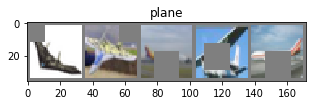

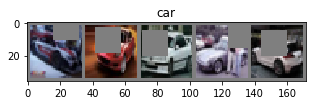

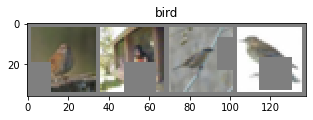

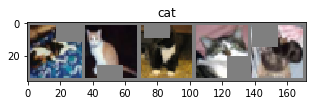

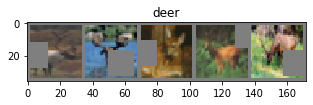

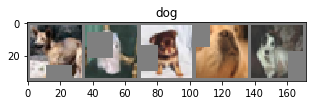

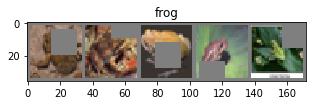

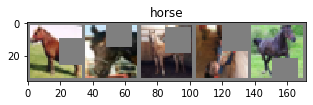

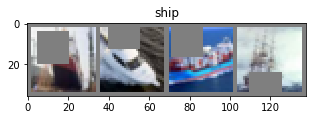

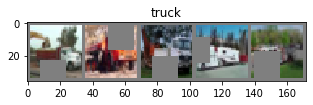

In [8]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Plot.plot_transormed_images(train_loader, classes)

### Best Training LR fnding

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


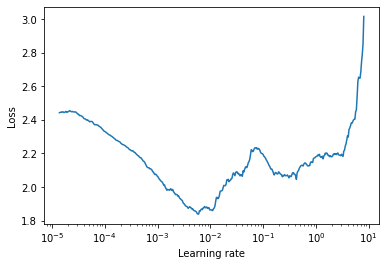

Best LR:  0.005801323103833379
Best loss 1.8384752680402021


In [8]:
# Use SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = helper_obj.get_l2_regularizer(weight_decay=0.001, lr=1e-5, momentum=0.9) #SGD with l2 regulizer
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=500, step_mode="exp")
lr_finder.plot()
training_lr = lr_finder.get_best_lr()
lr_finder.reset()

### Validation LR finding


Learning rate search finished. See the graph with {finder_name}.plot()


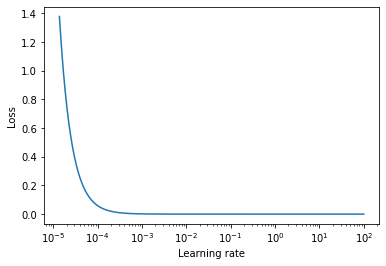

Best LR:  100.00000000000001
Best loss 1.763976498220905e-11


In [9]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=500, step_mode="exp")
lr_finder.plot(skip_end=0)
validation_lr = lr_finder.get_best_lr()
lr_finder.reset()

### Run Model

In [10]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
optimizer = helper_obj.get_l2_regularizer(lr=training_lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', verbose=True)
EPOCHS = 50
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_obj = Train()
test_obj = Test()
train_max_acc = []
train_min_loss = []
criterion = nn.CrossEntropyLoss()
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train_obj.train(model, device, train_loader, optimizer, criterion)
    if epoch < EPOCHS:
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=False, trueclassified_required=False, classes=classes, class_accuracy=90)
    else:
        # store only last epochsreult for misclassfied and trueclassified images
        test_obj.test(model, device, test_loader, criterion, misclassfied_required=True, trueclassified_required=True, classes=classes, class_accuracy=90)
    scheduler.step(metrics=test_obj.test_losses[-1])
    train_max_acc.append(train_obj.train_acc[-1])
    train_min_loss.append(train_obj.train_losses[-1])
miscassified_images = test_obj.misclassified_images
correctcassified_images = test_obj.trueclassified_images
test_losses = test_obj.test_losses
test_acc = test_obj.test_acc
print("Maximum Training Accuracy = ", max(train_max_acc))
print("Maximum Testing Accuracy = ", max(test_acc))




  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


Train Set: Train Loss=1.0938236713409424 Batch_id=781 Accuracy=49.43: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0159, Accuracy: 6445/10000 (64.45%)

EPOCH: 2


Train Set: Train Loss=0.373483270406723 Batch_id=781 Accuracy=66.31: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 7377/10000 (73.77%)

EPOCH: 3


Train Set: Train Loss=1.3756818771362305 Batch_id=781 Accuracy=72.40: 100%|██████████| 782/782 [01:50<00:00,  7.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0100, Accuracy: 7847/10000 (78.47%)

EPOCH: 4


Train Set: Train Loss=0.7517585754394531 Batch_id=781 Accuracy=76.06: 100%|██████████| 782/782 [01:49<00:00,  7.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 7956/10000 (79.56%)

EPOCH: 5


Train Set: Train Loss=1.1646318435668945 Batch_id=781 Accuracy=78.70: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0087, Accuracy: 8108/10000 (81.08%)

EPOCH: 6


Train Set: Train Loss=1.2177023887634277 Batch_id=781 Accuracy=80.34: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8175/10000 (81.75%)

EPOCH: 7


Train Set: Train Loss=0.6488347053527832 Batch_id=781 Accuracy=82.22: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 8205/10000 (82.05%)

EPOCH: 8


Train Set: Train Loss=0.4872150421142578 Batch_id=781 Accuracy=83.28: 100%|██████████| 782/782 [01:49<00:00,  7.13it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 8258/10000 (82.58%)

EPOCH: 9


Train Set: Train Loss=0.6202343106269836 Batch_id=781 Accuracy=84.05: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 8437/10000 (84.37%)

EPOCH: 10


Train Set: Train Loss=0.18294216692447662 Batch_id=781 Accuracy=84.85: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 8503/10000 (85.03%)

EPOCH: 11


Train Set: Train Loss=0.0939691960811615 Batch_id=781 Accuracy=85.68: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0068, Accuracy: 8513/10000 (85.13%)

EPOCH: 12


Train Set: Train Loss=0.3831321895122528 Batch_id=781 Accuracy=86.42: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8705/10000 (87.05%)

EPOCH: 13


Train Set: Train Loss=0.5326237082481384 Batch_id=781 Accuracy=87.00: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 8692/10000 (86.92%)

EPOCH: 14


Train Set: Train Loss=0.5101789832115173 Batch_id=781 Accuracy=87.56: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8719/10000 (87.19%)

EPOCH: 15


Train Set: Train Loss=0.6853307485580444 Batch_id=781 Accuracy=88.11: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8819/10000 (88.19%)

EPOCH: 16


Train Set: Train Loss=0.1864093840122223 Batch_id=781 Accuracy=88.52: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8840/10000 (88.40%)

EPOCH: 17


Train Set: Train Loss=0.5055659413337708 Batch_id=781 Accuracy=88.78: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 8862/10000 (88.62%)

EPOCH: 18


Train Set: Train Loss=0.13263313472270966 Batch_id=781 Accuracy=89.10: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8813/10000 (88.13%)

EPOCH: 19


Train Set: Train Loss=0.7577498555183411 Batch_id=781 Accuracy=89.68: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8658/10000 (86.58%)

EPOCH: 20


Train Set: Train Loss=0.6048669815063477 Batch_id=781 Accuracy=89.96: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8781/10000 (87.81%)

EPOCH: 21


Train Set: Train Loss=0.38815996050834656 Batch_id=781 Accuracy=90.23: 100%|██████████| 782/782 [01:51<00:00,  6.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8837/10000 (88.37%)

EPOCH: 22


Train Set: Train Loss=0.18571516871452332 Batch_id=781 Accuracy=90.54: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8827/10000 (88.27%)

EPOCH: 23


Train Set: Train Loss=0.25833818316459656 Batch_id=781 Accuracy=90.85: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0059, Accuracy: 8756/10000 (87.56%)

EPOCH: 24


Train Set: Train Loss=0.5646505951881409 Batch_id=781 Accuracy=91.05: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0066, Accuracy: 8614/10000 (86.14%)

EPOCH: 25


Train Set: Train Loss=1.0240671634674072 Batch_id=781 Accuracy=90.95: 100%|██████████| 782/782 [01:52<00:00,  6.98it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 8822/10000 (88.22%)

EPOCH: 26


Train Set: Train Loss=0.3021547794342041 Batch_id=781 Accuracy=91.52: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8942/10000 (89.42%)

EPOCH: 27


Train Set: Train Loss=0.21010243892669678 Batch_id=781 Accuracy=91.53: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8869/10000 (88.69%)

EPOCH: 28


Train Set: Train Loss=0.47674328088760376 Batch_id=781 Accuracy=91.81: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8971/10000 (89.71%)

EPOCH: 29


Train Set: Train Loss=0.09692826867103577 Batch_id=781 Accuracy=91.91: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8920/10000 (89.20%)

EPOCH: 30


Train Set: Train Loss=0.7906068563461304 Batch_id=781 Accuracy=92.17: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]



Test set: Average loss: 0.0046, Accuracy: 9020/10000 (90.20%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 98 %
Accuracy of   car : 97 %
Accuracy of  bird : 84 %
Accuracy of   cat : 78 %
Accuracy of  deer : 84 %
Accuracy of   dog : 89 %
Accuracy of  frog : 96 %
Accuracy of horse : 96 %
Accuracy of  ship : 95 %
Accuracy of truck : 89 %
EPOCH: 31


Train Set: Train Loss=0.3742244839668274 Batch_id=781 Accuracy=91.97: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 8805/10000 (88.05%)

EPOCH: 32


Train Set: Train Loss=0.4833279848098755 Batch_id=781 Accuracy=92.18: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 8975/10000 (89.75%)

EPOCH: 33


Train Set: Train Loss=0.5344544649124146 Batch_id=781 Accuracy=92.41: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8924/10000 (89.24%)

EPOCH: 34


Train Set: Train Loss=0.132868230342865 Batch_id=781 Accuracy=92.63: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8931/10000 (89.31%)

EPOCH: 35


Train Set: Train Loss=0.12115281820297241 Batch_id=781 Accuracy=92.65: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8990/10000 (89.90%)

EPOCH: 36


Train Set: Train Loss=0.5534744262695312 Batch_id=781 Accuracy=92.58: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 8933/10000 (89.33%)

EPOCH: 37


Train Set: Train Loss=0.2108643501996994 Batch_id=781 Accuracy=92.82: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 8928/10000 (89.28%)

EPOCH: 38


Train Set: Train Loss=0.07408329844474792 Batch_id=781 Accuracy=92.93: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 8961/10000 (89.61%)

EPOCH: 39


Train Set: Train Loss=0.12680688500404358 Batch_id=781 Accuracy=92.87: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0055, Accuracy: 8876/10000 (88.76%)

EPOCH: 40


Train Set: Train Loss=0.35222241282463074 Batch_id=781 Accuracy=93.28: 100%|██████████| 782/782 [01:51<00:00,  7.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 8879/10000 (88.79%)

EPOCH: 41


Train Set: Train Loss=0.7190727591514587 Batch_id=781 Accuracy=93.07: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 8989/10000 (89.89%)

Epoch    41: reducing learning rate of group 0 to 5.8013e-04.
EPOCH: 42


Train Set: Train Loss=0.433218777179718 Batch_id=781 Accuracy=96.12: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]



Test set: Average loss: 0.0034, Accuracy: 9275/10000 (92.75%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 98 %
Accuracy of   car : 92 %
Accuracy of  bird : 85 %
Accuracy of   cat : 78 %
Accuracy of  deer : 92 %
Accuracy of   dog : 89 %
Accuracy of  frog : 88 %
Accuracy of horse : 88 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %
EPOCH: 43


Train Set: Train Loss=0.08887150883674622 Batch_id=781 Accuracy=97.19: 100%|██████████| 782/782 [01:50<00:00,  7.06it/s]



Test set: Average loss: 0.0034, Accuracy: 9276/10000 (92.76%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 93 %
Accuracy of   car : 92 %
Accuracy of  bird : 95 %
Accuracy of   cat : 87 %
Accuracy of  deer : 94 %
Accuracy of   dog : 92 %
Accuracy of  frog : 94 %
Accuracy of horse : 93 %
Accuracy of  ship : 85 %
Accuracy of truck : 95 %
EPOCH: 44


Train Set: Train Loss=0.0753244161605835 Batch_id=781 Accuracy=97.47: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]



Test set: Average loss: 0.0033, Accuracy: 9296/10000 (92.96%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 94 %
Accuracy of   car : 93 %
Accuracy of  bird : 92 %
Accuracy of   cat : 91 %
Accuracy of  deer : 91 %
Accuracy of   dog : 82 %
Accuracy of  frog : 94 %
Accuracy of horse : 98 %
Accuracy of  ship : 98 %
Accuracy of truck : 93 %
EPOCH: 45


Train Set: Train Loss=0.04961833357810974 Batch_id=781 Accuracy=97.72: 100%|██████████| 782/782 [01:50<00:00,  7.07it/s]



Test set: Average loss: 0.0033, Accuracy: 9306/10000 (93.06%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 95 %
Accuracy of   car : 100 %
Accuracy of  bird : 90 %
Accuracy of   cat : 79 %
Accuracy of  deer : 90 %
Accuracy of   dog : 86 %
Accuracy of  frog : 91 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 95 %
EPOCH: 46


Train Set: Train Loss=0.07105506956577301 Batch_id=781 Accuracy=97.83: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]



Test set: Average loss: 0.0033, Accuracy: 9298/10000 (92.98%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 92 %
Accuracy of   car : 96 %
Accuracy of  bird : 82 %
Accuracy of   cat : 82 %
Accuracy of  deer : 98 %
Accuracy of   dog : 87 %
Accuracy of  frog : 95 %
Accuracy of horse : 96 %
Accuracy of  ship : 98 %
Accuracy of truck : 97 %
EPOCH: 47


Train Set: Train Loss=0.09152071177959442 Batch_id=781 Accuracy=97.96: 100%|██████████| 782/782 [01:50<00:00,  7.09it/s]



Test set: Average loss: 0.0033, Accuracy: 9322/10000 (93.22%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 96 %
Accuracy of   car : 98 %
Accuracy of  bird : 82 %
Accuracy of   cat : 91 %
Accuracy of  deer : 96 %
Accuracy of   dog : 79 %
Accuracy of  frog : 97 %
Accuracy of horse : 92 %
Accuracy of  ship : 98 %
Accuracy of truck : 96 %
EPOCH: 48


Train Set: Train Loss=0.0286099910736084 Batch_id=781 Accuracy=98.16: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]



Test set: Average loss: 0.0033, Accuracy: 9328/10000 (93.28%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 90 %
Accuracy of   cat : 82 %
Accuracy of  deer : 95 %
Accuracy of   dog : 91 %
Accuracy of  frog : 94 %
Accuracy of horse : 100 %
Accuracy of  ship : 98 %
Accuracy of truck : 93 %
EPOCH: 49


Train Set: Train Loss=0.20835934579372406 Batch_id=781 Accuracy=98.22: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]



Test set: Average loss: 0.0033, Accuracy: 9342/10000 (93.42%)



  0%|          | 0/782 [00:00<?, ?it/s]

Accuracy of plane : 95 %
Accuracy of   car : 98 %
Accuracy of  bird : 91 %
Accuracy of   cat : 80 %
Accuracy of  deer : 95 %
Accuracy of   dog : 89 %
Accuracy of  frog : 96 %
Accuracy of horse : 98 %
Accuracy of  ship : 98 %
Accuracy of truck : 100 %
EPOCH: 50


Train Set: Train Loss=0.06150984764099121 Batch_id=781 Accuracy=98.29: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]



Test set: Average loss: 0.0034, Accuracy: 9301/10000 (93.01%)

Accuracy of plane : 91 %
Accuracy of   car : 94 %
Accuracy of  bird : 90 %
Accuracy of   cat : 77 %
Accuracy of  deer : 96 %
Accuracy of   dog : 87 %
Accuracy of  frog : 96 %
Accuracy of horse : 95 %
Accuracy of  ship : 95 %
Accuracy of truck : 91 %
Maximum Training Accuracy =  98.29
Maximum Testing Accuracy =  93.42


In [0]:
from google.colab import files
# print("Our model: \n\n", model, '\n')
# print("The state dict keys: \n\n", model.state_dict().keys())
torch.save(model.state_dict(), 'checkpoint.pth')
files.download('checkpoint.pth')

In [16]:
len(miscassified_images)

0

### Visualizing gradcam results for correctly classified images in layer4

In [15]:
from torchvision.utils import make_grid
num_img = 3
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([miscassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, miscassified_images[index][0])
  images.extend([miscassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[{0}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[miscassified_images[index][2].item()])
  Plot.image_show1(make_grid(images, nrow=5), title=label, download_image="gradcam_correctclassified.png")

IndexError: ignored

###Visualizing Gradcam results in all 4 layers

In [0]:
image = correctcassified_images[6] #take one random image from correctly classidfied images
layer_details = [model.layer1, model.layer2, model.layer3, model.layer4]
for i, model_layer in enumerate(layer_details):
    images = []
    grad_cam = GradCAM(model, model_layer)
    mask, _ = grad_cam(torch.stack([image[0]]))
    heatmap, result = visualize_cam(mask, image[0])
    images.extend([image[0].cpu(), heatmap, result])
    label = "  1.[{0}] 2.[layer {1} visualization] 3.[GaradCam visualization]".format(classes[image[2].item()], i+1)
    Plot.image_show(make_grid(images, nrow=5), title=label, download_image="gradcam_layer{0}.png".format(i+1))



### Visualizing gradcam results for miss classified images in layer4

In [0]:
num_img = 5
for index in range(num_img):
  images = []
  grad_cam = GradCAM(model, model.layer4)
  mask, _ = grad_cam(torch.stack([miscassified_images[index][0]]))
  heatmap, result = visualize_cam(mask, miscassified_images[index][0])
  images.extend([miscassified_images[index][0].cpu(), heatmap, result])
  label = "  1.[A:{0} P:{1}] 2.[Layer visualization] 3.[GaradCam visualization]".format(classes[miscassified_images[index][2].item()],classes[miscassified_images[index][1].item()])
  Plot.image_show(make_grid(images, nrow=5), title=label,, download_image="gradcam_misclassified.png")

### Display graphs

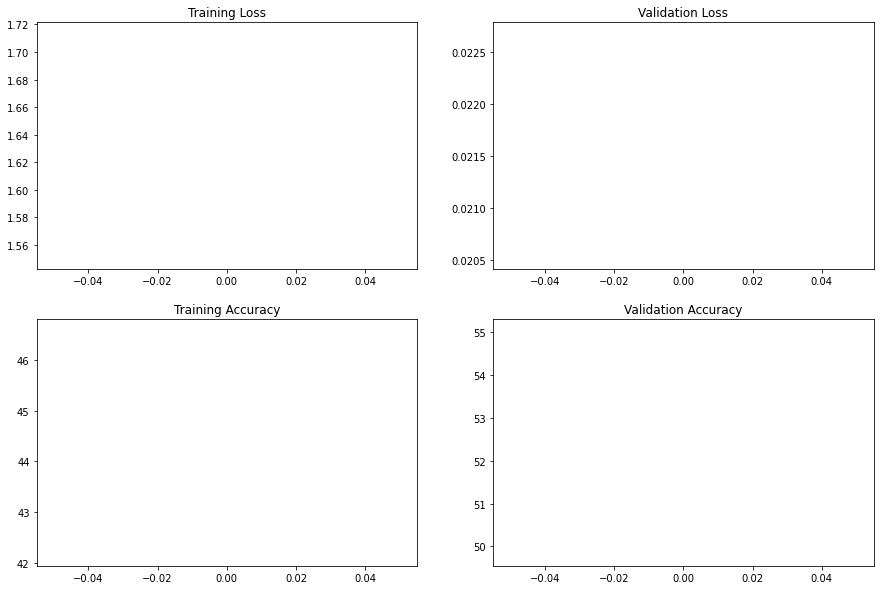

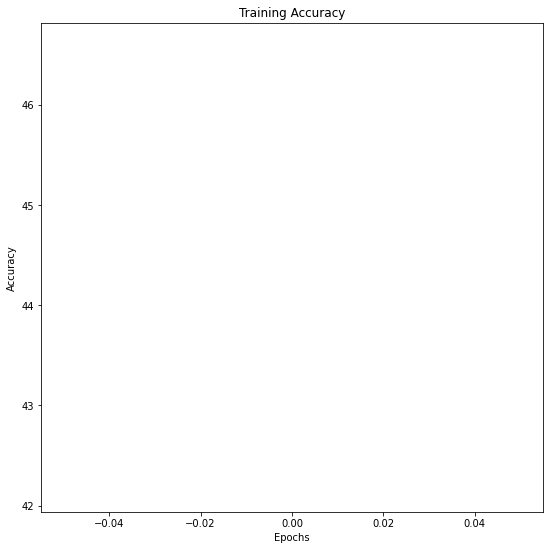

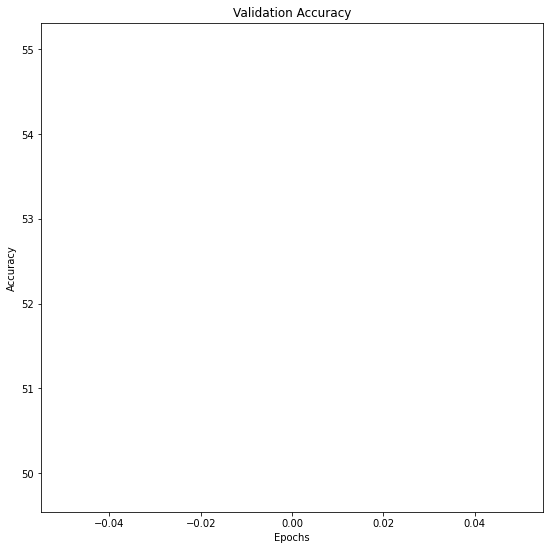

TypeError: ignored

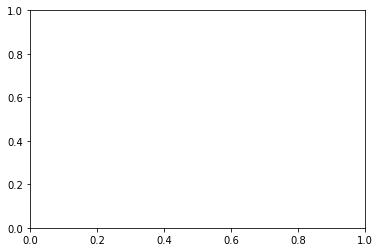

In [10]:
plt_obj = Plot(train_max_acc, train_min_loss, test_acc, test_losses)
# Plot all graph
plt_obj.display_all_plot()
#plot train accuracy graph
plt_obj.plot_train_graph()
#plot train loss graph
#plt_obj.plot_train_graph(plot_case="Loss")
#plot validation accuracy graph
plt_obj.plot_validation_graph()
#plot validation loss graph
#plt_obj.plot_validation_graph(plot_case="Loss")
#plot train and validation accuracy graph
plt_obj.plot_graph(plot_case="Accuracy")
#plot train and validation loss graph
plt_obj.plot_graph(plot_case="Loss")

### Plot misclassified images

In [0]:
Plot.plot_classified_images(classes, miscassified_images, image_name="gradcam_misclssified.png")


### Plot correct classified images



In [0]:
Plot.plot_classified_images(classes, correctcassified_images, image_name="gradcam_correctlyified.png")